### importing library 

In [ ]:
import re
import cv2 # Albumentation transform을 쓰려면 꼭 cv2 library를 이용해야함.
import time
import random
import warnings

from PIL import Image # PIL = Python Image Library
from sklearn.model_selection import GroupKFold


!pip install albumentations==0.4.6
import albumentations as A
from albumentations.pytorch import ToTensorV2
from albumentations.pytorch.transforms import ToTensorV2
from albumentations.core.transforms_interface import ImageOnlyTransform

import torch
import torchvision

from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator

from torch.utils.data import DataLoader, Dataset
from torch.utils.data.sampler import SequentialSampler

paddingSize= 0

warnings.filterwarnings("ignore")

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 117 kB 14.4 MB/s 
  Created wheel for albumentations: filename=albumentations-0.4.6-py3-none-any.whl size=65174 sha256=db856dd577a3acb0a3258f3974d4527d735a4d1f875c6ae01178b69d77868491
  Stored in directory: /root/.cache/pip/wheels/cf/34/0f/cb2a5f93561a181a4bcc84847ad6aaceea8b5a3127469616cc
Successfully built albumentations
  Attempting uninstall: albumentations
    Found existing installation: albumentations 1.2.1
    Uninstalling albumentations-1.2.1:
      Successfully uninstalled albumentations-1.2.1


### group K fold

- group by image_id
- 예측의 정확도를 확실히 평가하기 위해서는 train set & valid set에 포함된 image가 겹치지 않도록 할 필요가 있기때문에 이를위해 group k fold를 사용하였음

In [ ]:
gkf  = GroupKFold(n_splits = 5)
final_df['fold'] = -1
for fold, (train_idx, val_idx) in enumerate(gkf.split(final_df, groups = final_df.image_id.tolist())): # cf) tolist한다고 unqiue해지는건 아님
    final_df.loc[val_idx, 'fold'] = fold
final_df.head()

,image_id,class_name,class_id,ori_x_min,ori_y_min,ori_x_max,ori_y_max,ori_x_mid,ori_y_mid,ori_w,ori_h,fold
0,9a5094b2563a1ef3ff50dc5c7ff71345,Cardiomegaly,3,170,301,406,401,288,351,236,99,3
1,051132a778e61a86eb147c7c6f564dfe,Aortic enlargement,0,280,132,358,181,319,156,77,49,2
2,1c32170b4af4ce1a3030eb8167753b06,Pleural thickening,11,126,59,190,72,158,65,64,12,4
3,0c7a38f293d5f5e4846aa4ca6db4daf1,ILD,5,301,49,490,434,396,241,188,385,2
4,47ed17dcb2cbeec15182ed335a8b5a9e,Nodule/Mass,8,111,359,134,379,122,369,23,20,4


In [ ]:
final_df.groupby('fold')['image_id'].agg(lambda x: x.nunique()).reset_index()
# agg(적용하고 싶은 함수): 함수를 여러 열에 적용하는 함수
# nunique(): 데이터에 고유값들의 수를 출력해주는 함수. (데이터 고유값의 총 수를 알고 싶을때 유용한 함수)

,fold,image_id
0,0,879
1,1,879
2,2,879
3,3,878
4,4,879


In [ ]:
#그냥 가정 설정문으로 가정에 맞지않으면 assertionerror가 발생
IMG_SIZE = 512
assert final_df['ori_x_min'].all() <= IMG_SIZE
assert final_df['ori_y_min'].all() <= IMG_SIZE
assert final_df['ori_x_max'].all() <= IMG_SIZE
assert final_df['ori_y_max'].all() <= IMG_SIZE

In [ ]:
#확인겸
final_df[final_df.ori_y_min == final_df.ori_y_max]

,image_id,class_name,class_id,ori_x_min,ori_y_min,ori_x_max,ori_y_max,ori_x_mid,ori_y_mid,ori_w,ori_h,fold
11912,a1134e92282815efb505a93105083393,Pleural effusion,10,179,381,206,381,193,381,27,0,1


원래 y_max와 y_min이 별 차이가 나지 않았는데 normalization 후 다시 size(512x512) 재정의시 정수화함에따라 같은 값을 갖게되는 경우가 있었다.
이런 데이터는 삭제하기로 함.

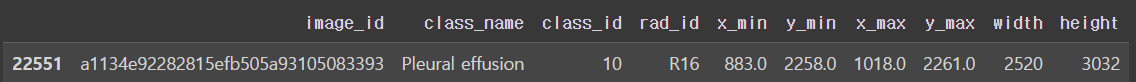

In [ ]:
final_df = final_df[final_df.ori_y_min != final_df.ori_y_max].reset_index()
final_df.head()

,index,image_id,class_name,class_id,ori_x_min,ori_y_min,ori_x_max,ori_y_max,ori_x_mid,ori_y_mid,ori_w,ori_h,fold
0,0,9a5094b2563a1ef3ff50dc5c7ff71345,Cardiomegaly,3,170,301,406,401,288,351,236,99,3
1,1,051132a778e61a86eb147c7c6f564dfe,Aortic enlargement,0,280,132,358,181,319,156,77,49,2
2,2,1c32170b4af4ce1a3030eb8167753b06,Pleural thickening,11,126,59,190,72,158,65,64,12,4
3,3,0c7a38f293d5f5e4846aa4ca6db4daf1,ILD,5,301,49,490,434,396,241,188,385,2
4,4,47ed17dcb2cbeec15182ed335a8b5a9e,Nodule/Mass,8,111,359,134,379,122,369,23,20,4


In [ ]:
final_df = final_df.drop('index', axis = 1)

In [ ]:
final_df

,image_id,class_name,class_id,ori_x_min,ori_y_min,ori_x_max,ori_y_max,ori_x_mid,ori_y_mid,ori_w,ori_h,fold
0,9a5094b2563a1ef3ff50dc5c7ff71345,Cardiomegaly,3,170,301,406,401,288,351,236,99,3
1,051132a778e61a86eb147c7c6f564dfe,Aortic enlargement,0,280,132,358,181,319,156,77,49,2
2,1c32170b4af4ce1a3030eb8167753b06,Pleural thickening,11,126,59,190,72,158,65,64,12,4
3,0c7a38f293d5f5e4846aa4ca6db4daf1,ILD,5,301,49,490,434,396,241,188,385,2
4,47ed17dcb2cbeec15182ed335a8b5a9e,Nodule/Mass,8,111,359,134,379,122,369,23,20,4
...,...,...,...,...,...,...,...,...,...,...,...,...
36090,b53d1dd80e99ca6bcef9d592f65d3321,Pleural effusion,10,53,275,124,355,89,315,71,80,0
36091,26d1d5a0ef2e692c6340e74859ffdc53,Pulmonary fibrosis,13,193,131,223,156,208,144,29,25,4
36092,22672ab82c290c20b86863291e25ef6c,ILD,5,74,135,198,308,136,222,123,172,4
36093,db169d0be36123bd55b866d6aa73983b,Other lesion,9,1,119,60,308,30,213,59,189,2


In [ ]:
class_dict = dict(set(zip(final_df.class_id, final_df.class_name)))
classes = []
for key in sorted(class_dict.keys()):
    classes.append(class_dict[key])

classes = ['_'] + classes   # adding background
classes

['_',
 'Aortic enlargement',
 'Atelectasis',
 'Calcification',
 'Cardiomegaly',
 'Consolidation',
 'ILD',
 'Infiltration',
 'Lung Opacity',
 'Nodule/Mass',
 'Other lesion',
 'Pleural effusion',
 'Pleural thickening',
 'Pneumothorax',
 'Pulmonary fibrosis']

### cv2.putText를 위한 함수 
- id to name

In [ ]:
def label_to_name(id):
  id = int(id)
  id = id-1
  if id == 0:
      return "Aortic enlargement"
  if id == 1:
      return "Atelectasis"
  if id == 2:
      return "Calcification"
  if id == 3:
      return "Cardiomegaly"
  if id == 4:
      return "Consolidation"
  if id == 5:
      return "ILD"
  if id == 6:
      return "Infiltration"
  if id == 7:
      return "Lung Opacity"
  if id == 8:
      return "Nodule/Mass"  
  if id == 9:
      return "Other lesion"
  if id == 10:
      return "Pleural effusion"
  if id == 11:
      return "Pleural thickening"
  if id == 12:
      return "Pneumothorax"
  if id == 13:
      return "Pulmonary fibrosis"
  else:
      return str(id)  

### pytorch 에서의 Deep learning
1.   dataset 객체 class 생성 (pytorch는 model에 들어갈 data의 class와 loader를 정의해주어야함.)
2.   dataloader로 dataset 불러오기
3.   trainset, validationset model에 넣고 model 학습
4.   model로 test set inference


In [ ]:
class VBDDataset(Dataset): # class to load training data
    def __init__(self, dataframe, image_dir, transforms=None):
        super().__init__()

        self.image_ids = dataframe['image_id'].unique() # image 고유 ID
        self.df = dataframe
        self.image_dir = image_dir
        self.transforms = transforms # data의 경로와 불러올 데이터들에 augmentation을 적용하기위해 transform 인자를 만듬

    def __getitem__(self, idx): # image index로 item 불러오기

        image_id = self.image_ids[idx]
        # image ID가 같은 dataframe 가져오기
        records = self.df[self.df['image_id'] == image_id]
        # cv2로 image 불러오기
        image = cv2.imread(f'{self.image_dir}/{image_id}.png', cv2.IMREAD_COLOR)
        # openCV로 각  color를 저장하는 방식인 BGR을 RGB로 변환
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
        # 0~1 사이로 scaling
        image /= 255.0
        boxes = records[['ori_x_min', 'ori_y_min', 'ori_x_max', 'ori_y_max']].values
        
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        # list를 torch tensor로 view 변환 (data definition)
        area = torch.as_tensor(area, dtype=torch.float32)
        # all the labels are shifted by 1 to accomodate background
        labels = torch.squeeze(torch.as_tensor((records.class_id.values+1,), dtype=torch.int64))
        
        # 모든 인스턴스는 crowd 상태가 아님을 가정
        iscrowd = torch.zeros((records.shape[0],), dtype=torch.int64)
        
        target = {}
        target['boxes'] = boxes
        target['labels'] = labels
        # target['masks'] = None
        target['image_id'] = torch.tensor([idx])
        target['area'] = area
        target['iscrowd'] = iscrowd
        # transform 적용
        if self.transforms:
            sample = {
                'image': image,
                'bboxes': target['boxes'],
                'labels': labels
            }
            sample = self.transforms(**sample)
            image = sample['image']
            
            target['boxes'] = torch.as_tensor(sample['bboxes'])

        return image, target, image_id

    def __len__(self):
        return self.image_ids.shape[0]

In [ ]:
dt = VBDDataset(final_df, train_dir)

In [ ]:
# 이미지 tensor로 바꾸기
def get_train_transform():
    return A.Compose([
        ToTensorV2(p=1.0) # albumentations의 경우는 normalize 후 ToTensorV2 사용
    ], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})

def get_valid_transform():
    return A.Compose([
        ToTensorV2(p=1.0)
    ], bbox_params={'format': 'pascal_voc', 'label_fields': ['labels']})

### 미리 학습된 model로 부터 fine tuning

coco 로 미리 학습 된 model 읽기

In [ ]:
#load a model; pre-trained on COCO
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth


  0%|          | 0.00/160M [00:00<?, ?B/s]

분류기를 새로운 것을 교체

In [ ]:
num_classes = 15  # 14 classes + background

# 분류기에서 사용할 입력 특징의 차원 정보 얻음
in_features = model.roi_heads.box_predictor.cls_score.in_features

# 미리 학습된 모델의 머리 부분을 새로운 것으로 교체
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

In [ ]:
# A Class for keeping track of average
class Averager:
    def __init__(self):
        self.current_total = 0.0
        self.iterations = 0.0

    def send(self, value):
        self.current_total += value
        self.iterations += 1

    @property
    def value(self):
        if self.iterations == 0:
            return 0
        else:
            return 1.0 * self.current_total / self.iterations

    def reset(self):
        self.current_total = 0.0
        self.iterations = 0.0

### testing sample

In [ ]:
def collate_fn(batch):
    return tuple(zip(*batch))

train_dataset = VBDDataset(final_df, train_dir, get_train_transform())
valid_dataset = VBDDataset(final_df, train_dir, get_valid_transform())


train_data_loader = DataLoader(
    train_dataset,
    batch_size=8,
    shuffle=False,
    num_workers=4,
    collate_fn=collate_fn
)

valid_data_loader = DataLoader(
    valid_dataset,
    batch_size=4,
    shuffle=False,
    num_workers=4,
    collate_fn=collate_fn
)

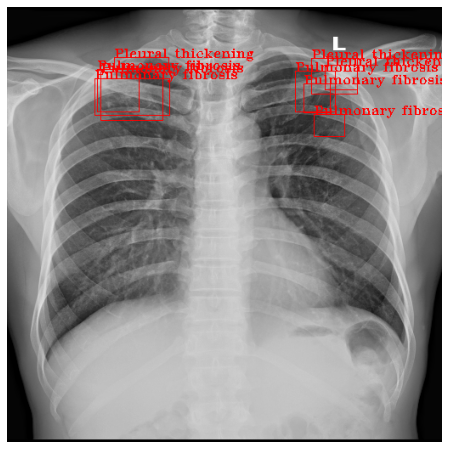

In [ ]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

images, targets, image_ids = next(iter(train_data_loader))
images = list(image.to(device) for image in images)
targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

boxes = targets[2]['boxes'].cpu().numpy().astype(np.int32)
sample = images[2].permute(1,2,0).cpu().numpy()
labels= targets[2]['labels'].cpu().numpy().astype(np.int32)
fig, ax = plt.subplots(1, 1, figsize=(16, 8))

for i in range(len(boxes)):
    sample = cv2.rectangle(sample,
                  (boxes[i][0], boxes[i][1]),
                  (boxes[i][2], boxes[i][3]),
                  (220, 0, 0), 1)
    sample = cv2.putText(sample, label_to_name(labels[i]), (int(boxes[i][0]), int(boxes[i][1])),cv2.FONT_HERSHEY_TRIPLEX, 0.5, (255, 0, 0), 1, cv2.LINE_AA)

ax.set_axis_off()
ax.imshow(sample)

### training

In [ ]:
def get_dataloaders(df, trn_idx, val_idx):
    
    train_ = df.loc[trn_idx,:].reset_index(drop=True)
    valid_ = df.loc[val_idx,:].reset_index(drop=True)
        
    def collate_fn(batch):
        return tuple(zip(*batch))

    train_dataset = VBDDataset(train_, train_dir, get_train_transform())
    valid_dataset = VBDDataset(valid_, train_dir, get_valid_transform())

    train_data_loader = DataLoader(
        train_dataset,
        batch_size=8,
        shuffle=False,
        num_workers=4,
        collate_fn=collate_fn
    )

    valid_data_loader = DataLoader(
        valid_dataset,
        batch_size=4,
        shuffle=False,
        num_workers=4,
        collate_fn=collate_fn
    )
    
    return train_data_loader, valid_data_loader

In [ ]:
def train_model(model, dataloader, device, epochs, optimizer, lr_scheduler, fold):
    
    best_loss = 1e10
    loss_hist = Averager()
    itr = 1
    all_losses = []

    for epoch in range(epochs):
        loss_hist.reset() 
    
        for images, targets, image_ids in dataloader:

            images = list(image.to(device) for image in images)
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

            loss_dict = model(images, targets)

            losses = sum(loss for loss in loss_dict.values())
            loss_value = losses.item()

            loss_hist.send(loss_value)
            all_losses.append(loss_value)
            
            optimizer.zero_grad()
            losses.backward()
            optimizer.step()

            if itr % 50 == 0:
                print(f"Iteration #{itr} loss: {loss_value}")

            itr += 1        
        # saving the model based on training loss for now. - later can be moved to validation
        if loss_hist.value < best_loss:
            best_loss = loss_hist.value
            torch.save(model.state_dict(), f'fasterrcnn_model_{fold}.pt')

        # update the learning rate
        if lr_scheduler is not None:
            lr_scheduler.step()

        print(f"Epoch #{epoch} loss: {loss_hist.value}\n")
        
    return all_losses

In [ ]:
def validate_model(model, dataloader, device):
    print("\n Starting Validation ... ")
    loss_hist = Averager()
    itr = 1

    loss_hist.reset() 

    for images, targets, image_ids in dataloader:

        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        loss_dict = model(images, targets)

        losses = sum(loss for loss in loss_dict.values())
        loss_value = losses.item()

        loss_hist.send(loss_value)

        if itr % 50 == 0:
            print(f"Iteration #{itr} loss: {loss_value}")

        itr += 1

    print(f"\nFinal loss: {loss_hist.value}")

In [ ]:
def run_fold(fold):
    print(f"Starting fold {fold}")
    start = time.time()
    trn_idx = final_df[final_df['fold'] != fold].index
    val_idx = final_df[final_df['fold'] == fold].index
    
    
    trainloader, valloader = get_dataloaders(final_df, trn_idx, val_idx)
    
    loss_hist = train_model(model, trainloader, device, epochs, optimizer, lr_scheduler, fold)
    
    # plot training loss
    plt.figure(figsize=(8,5))
    plt.plot(loss_hist)
    plt.title("Training Loss Statistic", size=17)
    plt.xlabel("Iteration", size=15)
    plt.ylabel("Loss Value", size=15)

    plt.show()
    
    validate_model(model, valloader, device)
    
    print(f"Completed Fold {fold} in {round(time.time()-start, 2)} seconds")

In [ ]:
model.to(device)

# set params for model
params = [p for p in model.parameters() if p.requires_grad]

# set optimizer
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)

# set lr scheduler
lr_scheduler = None

# set epochs
epochs = 10

# set folds
num_folds = 1

Starting fold 0
Iteration #50 loss: 1.1169182062149048
Iteration #100 loss: 1.264062523841858
Iteration #150 loss: 0.691567599773407
Iteration #200 loss: 0.8691445589065552
Iteration #250 loss: 1.0748133659362793
Iteration #300 loss: 0.787904679775238
Iteration #350 loss: 0.5092889666557312
Iteration #400 loss: 0.6087238192558289
Epoch #0 loss: 0.8545013584196568

Iteration #450 loss: 0.9231672286987305
Iteration #500 loss: 0.7477344274520874
Iteration #550 loss: 0.9143509864807129
Iteration #600 loss: 0.824226438999176
Iteration #650 loss: 0.7492454648017883
Iteration #700 loss: 0.5444098711013794
Iteration #750 loss: 0.7792507410049438
Iteration #800 loss: 0.6148431301116943
Iteration #850 loss: 0.6731081604957581
Epoch #1 loss: 0.7519769587638703

Iteration #900 loss: 0.7482225894927979
Iteration #950 loss: 1.1215511560440063
Iteration #1000 loss: 0.8032543659210205
Iteration #1050 loss: 0.9449547529220581
Iteration #1100 loss: 0.7937233448028564
Iteration #1150 loss: 0.785130202770

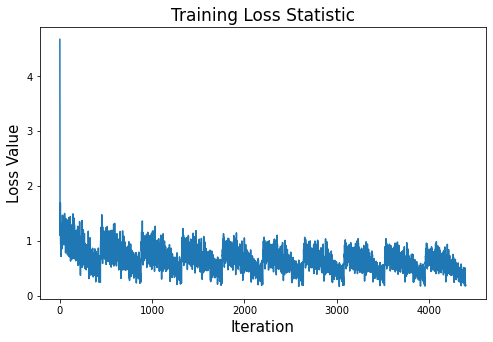


 Starting Validation ... 
Iteration #50 loss: 2.087923526763916
Iteration #100 loss: 1.015902042388916
Iteration #150 loss: 1.1267523765563965
Iteration #200 loss: 0.6915047764778137

Final loss: 1.0244398490949111
Completed Fold 0 in 8002.79 seconds


In [ ]:
for fold in range(num_folds):
    run_fold(fold)

### visualize model

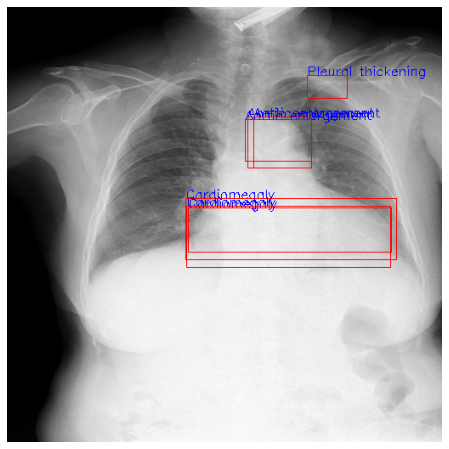

In [ ]:
images, targets, image_ids = next(iter(valid_data_loader))

images = list(img.to(device) for img in images)
targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

boxes = targets[1]['boxes'].cpu().numpy().astype(np.int32)
sample = images[1].permute(1,2,0).cpu().numpy()
clss = targets[1]['labels'].cpu().numpy().astype(np.int32)

model.eval()
cpu_device = torch.device("cpu")

outputs = model(images)
outputs = [{k: v.to(cpu_device) for k, v in t.items()} for t in outputs]

fig, ax = plt.subplots(1, 1, figsize=(16, 8))
for box, clas in zip(boxes, clss):
    cv2.putText(sample, f"{classes[clas]}", (box[0], box[1]), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0,0,255), 1)
    cv2.rectangle(sample,
                  (box[0], box[1]),
                  (box[2], box[3]),
                  (220, 0, 0), 1)
    
ax.set_axis_off()
ax.imshow(sample)

### inference

In [ ]:
train_dir = '/content/vinbigdata/train'
test_dir =  '/content/vinbigdata/test'
train_df = pd.read_csv('/content/vinbigdata/train.csv')
test_df = pd.read_csv('/content/vinbigdata/sample_submission.csv')
test_df.head()

,image_id,PredictionString
0,002a34c58c5b758217ed1f584ccbcfe9,14 1 0 0 1 1
1,004f33259ee4aef671c2b95d54e4be68,14 1 0 0 1 1
2,008bdde2af2462e86fd373a445d0f4cd,14 1 0 0 1 1
3,009bc039326338823ca3aa84381f17f1,14 1 0 0 1 1
4,00a2145de1886cb9eb88869c85d74080,14 1 0 0 1 1


In [ ]:
class VinBigTestDataset(Dataset):
    
    def __init__(self, dataframe, image_dir, transforms=None):
        super().__init__()
        
        self.image_ids = dataframe["image_id"].unique()
        self.df = dataframe
        self.image_dir = image_dir
        self.transforms = transforms
        
    def __getitem__(self, index):
        
        image_id = self.image_ids[index]
        records = self.df[(self.df['image_id'] == image_id)]
        
        image = cv2.imread(f'{self.image_dir}/{image_id}.png', cv2.IMREAD_COLOR)    
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
        image /= 255.0 #normalization

        
        if self.transforms:
            sample = {
                'image': image,
            }
            sample = self.transforms(**sample)
            image = sample['image']

        return image, image_id
    
    def __len__(self):
        return self.image_ids.shape[0]

In [ ]:
def get_test_transform():
    return A.Compose([
        ToTensorV2(p=1.0)
    ])

In [ ]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

#load a model; pre-trained on COCO
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=False) #내 weight upload하려고 이번엔 false

num_classes = 15  # 14 classes + background

# get number of input features for the classifier
in_features = model.roi_heads.box_predictor.cls_score.in_features

# replace the pre-trained head with a new one
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

model.load_state_dict(torch.load('/content/fasterrcnn_model_0.pt')) #weight upload
model.eval()

x = model.to(device)

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

In [ ]:
def collate_fn(batch):
    return tuple(zip(*batch))

test_dataset = VinBigTestDataset(test_df, test_dir, get_test_transform())

test_data_loader = DataLoader(
    test_dataset,
    batch_size=8,
    shuffle=False,
    num_workers=1, #gpu 개수
    drop_last=False,
    collate_fn=collate_fn
)

In [ ]:
def format_prediction_string(labels, boxes, scores):
    pred_strings = []
    for j in zip(labels, scores, boxes):
        pred_strings.append("{0} {1:.4f} {2} {3} {4} {5}".format(
            j[0], j[1], j[2][0], j[2][1], j[2][2], j[2][3]))

    return " ".join(pred_strings)

In [ ]:
detection_threshold = 0.4
results = []

with torch.no_grad():

    for images, image_ids in test_data_loader:

        images = list(image.to(device) for image in images)
        outputs = model(images)

        for i, image in enumerate(images):

            image_id = image_ids[i]

            result = {
                'image_id': image_id,
                'PredictionString': '14 1.0 0 0 1 1'
            }

            boxes = outputs[i]['boxes'].data.cpu().numpy()
            labels = outputs[i]['labels'].data.cpu().numpy()
            scores = outputs[i]['scores'].data.cpu().numpy()

            if len(boxes) > 0:
                labels = labels - 1
                labels[labels == -1] = 14

                selected = scores >= detection_threshold

                boxes = boxes[selected].astype(np.int32)
                scores = scores[selected]
                labels = labels[selected]

                if len(boxes) > 0:
                    result = {
                        'image_id': image_id,
                        'PredictionString': format_prediction_string(labels, boxes, scores)
                    }


            results.append(result)

In [ ]:
test_df = pd.DataFrame(results, columns=['image_id', 'PredictionString'])
test_df.head()

,image_id,PredictionString
0,002a34c58c5b758217ed1f584ccbcfe9,11 0.8010 300 56 372 73 3 0.5449 172 240 410 3...
1,004f33259ee4aef671c2b95d54e4be68,0 0.9483 260 99 310 151
2,008bdde2af2462e86fd373a445d0f4cd,0 0.9437 314 145 384 210 3 0.9154 237 238 424 320
3,009bc039326338823ca3aa84381f17f1,3 0.8660 166 226 392 285 0 0.6746 252 98 311 1...
4,00a2145de1886cb9eb88869c85d74080,3 0.9878 186 272 439 353


In [ ]:
sample = images[1].permute(1,2,0).cpu().numpy()
boxes = outputs[1]['boxes'].data.cpu().numpy().astype(np.int32)
scores = outputs[1]['scores'].data.cpu().numpy()
clss = outputs[1]['labels'].data.cpu().numpy().astype(np.int32)

boxes = boxes[scores >= detection_threshold].astype(np.int32)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


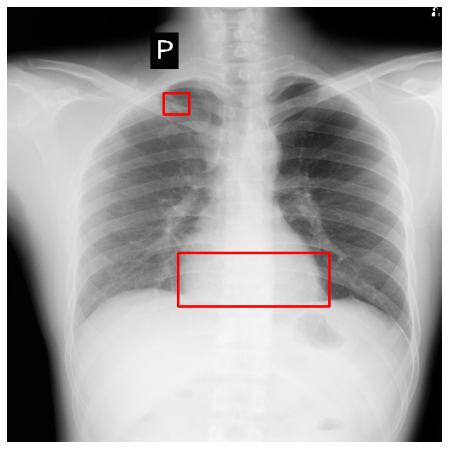

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(16, 8))

for box in boxes:
    cv2.rectangle(sample,
                  (box[0], box[1]),
                  (box[2], box[3]),
                  (220, 0, 0), 2)
    
ax.set_axis_off()
ax.imshow(sample)

In [ ]:
test_df.to_csv('Adata_10epoch_submission.csv', index=False)

### inference 한 결과 visulaizing

In [ ]:
import pandas as pd
test_df = pd.read_csv('/content/drive/MyDrive/KDT/offline/project/predictionresult/Adata_10epoch_submission.csv')
test_df

,image_id,PredictionString
0,002a34c58c5b758217ed1f584ccbcfe9,3 0.8381 178 246 417 323 9 0.4269 199 138 322 384
1,004f33259ee4aef671c2b95d54e4be68,0 0.9425 262 100 310 145 0 0.5152 239 100 311 165
2,008bdde2af2462e86fd373a445d0f4cd,0 0.9258 309 145 385 205 3 0.8902 240 240 426 ...
3,009bc039326338823ca3aa84381f17f1,3 0.8387 170 223 388 282 0 0.7617 256 99 309 151
4,00a2145de1886cb9eb88869c85d74080,3 0.9864 184 274 443 357 0 0.8570 269 151 324 197
...,...,...
2995,ff91fb82429a27521bbec8569b041f02,0 0.9521 272 103 312 146 3 0.7729 207 236 393 ...
2996,ff9fcc4087ed5e941209aa3fa948e364,0 0.9046 183 130 322 249 0 0.8339 257 124 313 ...
2997,ffaa288c8abca300974f043b57d81521,9 0.8179 199 102 310 379 10 0.6094 370 276 446...
2998,ffc441e0c8b7153844047483a577e7c3,14 1.0 0 0 1 1


In [ ]:
test_dir =  '/content/vinbigdata/test/'

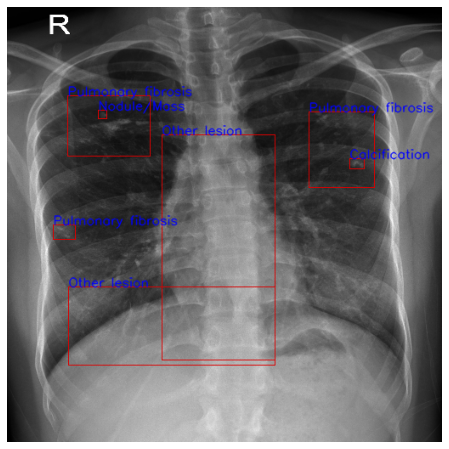

In [ ]:
samp_data = test_df.iloc[13].PredictionString.split(' ')
samp_len = len(samp_data)

img0_labels = []
img0_bboxes = []

fig, ax = plt.subplots(1, 1, figsize=(8, 8))
img0 = cv2.imread(test_dir + test_df.iloc[13].image_id +'.png', cv2.IMREAD_COLOR)
img0_labels = [samp_data[i] for i in range(samp_len) if i % 6 == 0]
img0_bboxes = [samp_data[i] for i in range(samp_len) if i % 6 != 0 and i % 6 != 1]

cnt = 0
for cls in img0_labels:
  img0 = cv2.rectangle(img0,
                       (int(img0_bboxes[cnt]), int(img0_bboxes[cnt + 1])),
                       (int(img0_bboxes[cnt + 2]), int(img0_bboxes[cnt + 3])),
                       (220, 0, 0), 1)
  img0 = cv2.putText(img0, label_to_name(int(cls)+1), (int(img0_bboxes[cnt]), int(img0_bboxes[cnt + 1])), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0,0,255), 1, cv2.LINE_AA)
  cnt += 4


ax.set_axis_off()
ax.imshow(img0)